# Introduction

In this assignment, we will use loan data from kaggle to predict whether a loan is healthy or not. Note that there are three files. This is the main file for our submission. We also have two supplementary files. The first supplementary file shows 'proof' or 'output' of our best 'feature' selection and best 'hyperparameter' selection algorithms for a random forest model that we use later on in this main file (that supplementary file took about 18 hours to run and required Colab Pro's resources). Note that this file should only take 15 minutes to run (at a maximum) and does not exceed Colab's 12GB ram requirement. We ensured that this would happen in this file by using a sample of the dataset (300K rows rather than >1.6MM rows) for our analysis. However, in a second supplementary file, we run this main file (excluding one of the models) on the entire dataset (we used Colab Pro to effectuate this). The model outputs are similar regardless of whether we use a sample of the data-set (or) the entire data-set. Please let us know if you have any questions.

# Import Data

Import necessary modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
from collections import Counter
from google.colab import drive # using to connect to kaggle for our dataset

Download the dataset (note that you will have to upload a kaggle.json file to be able to use this)

In [ ]:
# download dataset:
from google.colab import drive
drive.mount('/content/drive')
!mkdir ~/.kaggle
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# Download dataset
!!kaggle datasets download -d adarshsng/lending-club-loan-data-csv
# Unzip folder in Colab content folder
!unzip /content/lending-club-loan-data-csv.zip

Mounted at /content/drive
Archive:  /content/lending-club-loan-data-csv.zip
  inflating: LCDataDictionary.xlsx   
  inflating: loan.csv                


Read in data in chunks.

In [ ]:
import time
start = time.time()
#read data in chunks
chunk = pd.read_csv('loan.csv',chunksize=250000, low_memory=False)
end = time.time()
print("Read csv with chunks: ",(end-start),"sec")
df = pd.concat(chunk)

Read csv with chunks:  0.003821849822998047 sec


In [ ]:
# delete unnecessary variables to save on RAM
del start, end, chunk

The data should have >2MM rows which is too large for Colab's 12GB RAM limitations. Ultimately, we will sample a data-set from this global sample to work within Colab's limitations given the TA's guidance to avoid using Colab Pro. However, note, once again, that we have a supplementary file that analyzes the entire data-set (requires Colab Pro and takes about 45-60 mins to run).

In [ ]:
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260663,NaN,NaN,12000,12000,12000.0,60 months,14.08,279.72,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260664,NaN,NaN,12000,12000,12000.0,60 months,25.82,358.01,E,E4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260665,NaN,NaN,10000,10000,10000.0,36 months,11.99,332.10,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260666,NaN,NaN,12000,12000,12000.0,60 months,21.45,327.69,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning and Data Wrangling

## Handling null values


First, let us handle the null values in our data-set. In this next cell, we will eliminate those columns within which > 30% of the column has null values.

In [ ]:
rows = len(df['id'])

drop_columns = []

for col in list(df.columns):
  if df[col].isnull().sum() >= rows*.3:
    drop_columns.append(col)
    print("We are dropping the column titled: " + col)
df = df.drop(columns=drop_columns)

We are dropping the column titled: id
We are dropping the column titled: member_id
We are dropping the column titled: url
We are dropping the column titled: desc
We are dropping the column titled: mths_since_last_delinq
We are dropping the column titled: mths_since_last_record
We are dropping the column titled: next_pymnt_d
We are dropping the column titled: mths_since_last_major_derog
We are dropping the column titled: annual_inc_joint
We are dropping the column titled: dti_joint
We are dropping the column titled: verification_status_joint
We are dropping the column titled: open_acc_6m
We are dropping the column titled: open_act_il
We are dropping the column titled: open_il_12m
We are dropping the column titled: open_il_24m
We are dropping the column titled: mths_since_rcnt_il
We are dropping the column titled: total_bal_il
We are dropping the column titled: il_util
We are dropping the column titled: open_rv_12m
We are dropping the column titled: open_rv_24m
We are dropping the column

In [ ]:
# delete unnecessary variables to save on RAM
del drop_columns

Let us make sure that df was updated as expected.

In [ ]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,...,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,...,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,...,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,...,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,...,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260663,12000,12000,12000.0,60 months,14.08,279.72,C,C3,house keeper,10+ years,...,66.7,0.0,0.0,73948.0,45212.0,6200.0,49448.0,N,Cash,N
2260664,12000,12000,12000.0,60 months,25.82,358.01,E,E4,Skilled Labor,< 1 year,...,50.0,0.0,0.0,382275.0,12928.0,11400.0,12125.0,N,Cash,N
2260665,10000,10000,10000.0,36 months,11.99,332.10,B,B5,Teacher,10+ years,...,100.0,0.0,0.0,203417.0,36448.0,2000.0,29317.0,N,Cash,N
2260666,12000,12000,12000.0,60 months,21.45,327.69,D,D5,NaN,NaN,...,0.0,0.0,0.0,118975.0,65238.0,22000.0,81975.0,N,Cash,N


Now let us check the proportion of null values in each column.

In [ ]:
for col in list(df.columns):
  if df[col].isnull().sum()/rows > 0:
    print(str(col)+": "+ str(round(df[col].isnull().sum()/rows,4)))

emp_title: 0.0739
emp_length: 0.065
annual_inc: 0.0
title: 0.0103
zip_code: 0.0
dti: 0.0008
delinq_2yrs: 0.0
earliest_cr_line: 0.0
inq_last_6mths: 0.0
open_acc: 0.0
pub_rec: 0.0
revol_util: 0.0008
total_acc: 0.0
last_pymnt_d: 0.0011
last_credit_pull_d: 0.0
collections_12_mths_ex_med: 0.0001
acc_now_delinq: 0.0
tot_coll_amt: 0.0311
tot_cur_bal: 0.0311
total_rev_hi_lim: 0.0311
acc_open_past_24mths: 0.0221
avg_cur_bal: 0.0311
bc_open_to_buy: 0.0331
bc_util: 0.0336
chargeoff_within_12_mths: 0.0001
delinq_amnt: 0.0
mo_sin_old_il_acct: 0.0615
mo_sin_old_rev_tl_op: 0.0311
mo_sin_rcnt_rev_tl_op: 0.0311
mo_sin_rcnt_tl: 0.0311
mort_acc: 0.0221
mths_since_recent_bc: 0.0325
mths_since_recent_inq: 0.1307
num_accts_ever_120_pd: 0.0311
num_actv_bc_tl: 0.0311
num_actv_rev_tl: 0.0311
num_bc_sats: 0.0259
num_bc_tl: 0.0311
num_il_tl: 0.0311
num_op_rev_tl: 0.0311
num_rev_accts: 0.0311
num_rev_tl_bal_gt_0: 0.0311
num_sats: 0.0259
num_tl_120dpd_2m: 0.068
num_tl_30dpd: 0.0311
num_tl_90g_dpd_24m: 0.0311
num_t

Each column has a limited proportion of null values; hence, we think it is fine to just drop these rows given the size of the dataset.

In [ ]:
df = df.dropna()

In [ ]:
# check df again
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,...,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,...,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,...,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,...,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,...,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260658,15000,15000,15000.0,60 months,16.02,364.94,C,C5,Instructional Designer,< 1 year,...,0.0,0.0,0.0,267274.0,239081.0,22900.0,239074.0,N,Cash,N
2260662,30000,30000,30000.0,60 months,30.75,984.47,F,F5,Sales,6 years,...,50.0,0.0,0.0,201286.0,68680.0,16500.0,64086.0,N,Cash,N
2260663,12000,12000,12000.0,60 months,14.08,279.72,C,C3,house keeper,10+ years,...,66.7,0.0,0.0,73948.0,45212.0,6200.0,49448.0,N,Cash,N
2260664,12000,12000,12000.0,60 months,25.82,358.01,E,E4,Skilled Labor,< 1 year,...,50.0,0.0,0.0,382275.0,12928.0,11400.0,12125.0,N,Cash,N


In [ ]:
del rows

Our dataset is too large to work with; hence, we will use a sub-set.

In [ ]:
seed = 42
df = df.sample(n = 300000, random_state=seed)

In [ ]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
261309,9000,9000,9000.0,36 months,6.83,277.20,A,A3,Test Engineer,5 years,...,0.0,0.0,0.0,295439.0,18346.0,14100.0,22603.0,N,Cash,N
310885,30000,30000,30000.0,60 months,18.45,769.17,D,D2,Production manager / programmer,10+ years,...,100.0,0.0,0.0,160943.0,30689.0,23800.0,5044.0,N,Cash,N
1909821,15000,15000,15000.0,36 months,7.69,467.91,A,A4,Department Manager,10+ years,...,50.0,0.0,0.0,293143.0,58613.0,9500.0,48543.0,N,Cash,N
180491,30000,30000,30000.0,60 months,13.56,691.23,C,C1,Officer,10+ years,...,0.0,0.0,0.0,412315.0,33744.0,36500.0,27865.0,N,Cash,N
1345526,5600,5600,5600.0,36 months,14.99,194.10,C,C5,Driver/Warehouse,6 years,...,0.0,0.0,0.0,86687.0,101623.0,4700.0,78787.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871946,40000,40000,40000.0,36 months,13.99,1366.92,C,C3,Director of Curriculum,10+ years,...,60.0,0.0,0.0,125100.0,95646.0,125100.0,0.0,N,Cash,N
1316255,2000,2000,2000.0,36 months,12.39,66.81,C,C1,Educator,10+ years,...,100.0,0.0,0.0,420493.0,114386.0,38200.0,75793.0,N,Cash,N
1152639,16000,16000,16000.0,60 months,13.33,366.76,C,C3,Supervisor,10+ years,...,50.0,0.0,0.0,39961.0,13040.0,3100.0,34961.0,N,Cash,N
340490,14000,14000,14000.0,36 months,17.47,502.42,D,D1,Property Manager,4 years,...,100.0,0.0,0.0,50529.0,31383.0,13000.0,26129.0,N,Cash,N


## Data cleaning

This section includes general data cleaning as well as casting data types to the appropriate data types

In [ ]:
#We will replace strings within emp_length to ensure that this feature only contains numeric information
df['emp_length'] = df['emp_length'].apply(lambda x: str(x).replace(" years", "").replace(" year", "").replace("< ","").replace("+",""))

#We will also reset the index
df = df.reset_index(drop=True)

In [ ]:
#We ensure that term only contains numeric information
df['term'] = df['term'].apply(lambda x: x.replace(" months", "")).astype('int64')

There are four variables ('issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d') that refer to the date when the loan was issued, the earliest credit line that the borrower borrowed, the last payment date made by the borrower, and the last credit report pulled on the borrower, respectively. We are going to use these variables to prepare another variable that is specific to each borrower which represents the borrower's seasoning. This will be 'earliest_cr_line' minus 'last_pymnt_d'. We will use this special variable and drop the other variables. Ultimately, we are trying to bring our dataset to a strict dataset of numbers that can be put into machine learning models.

In [ ]:
df = df.drop(columns=['issue_d', 'last_credit_pull_d'])

In [ ]:
# write function to convert date time string in the following columns
from datetime import datetime
def convert_to_date(datestring):
  dt = datetime.strptime(datestring, '%b-%Y')
  return dt

In [ ]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: convert_to_date(x))
df['last_pymnt_d'] = df['last_pymnt_d'].apply(lambda x: convert_to_date(x))

In [ ]:
df['seasoning'] = (df['last_pymnt_d'] - df['earliest_cr_line'])
df = df.drop(columns=['last_pymnt_d', 'earliest_cr_line'])

In [ ]:
df['seasoning'] = df['seasoning'].apply(lambda x: x.days)

In [ ]:
pd.set_option('display.max_columns', None)
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,seasoning
0,9000,9000,9000.0,36,6.83,277.20,A,A3,Test Engineer,5,MORTGAGE,137000.0,Not Verified,Current,n,debt_consolidation,Debt consolidation,181xx,PA,6.60,1.0,0.0,6.0,0.0,8757,62.1,11.0,w,7390.90,7390.90,1954.820000,1954.82,1609.10,345.72,0.0,0.0,0.0,277.20,0.0,1,Individual,0.0,0.0,206519.0,14100.0,1.0,34420.0,5343.0,62.1,0.0,0.0,130.0,72.0,7.0,7.0,3.0,7.0,7.0,1.0,3.0,3.0,3.0,3.0,5.0,3.0,3.0,3.0,6.0,0.0,0.0,1.0,1.0,81.8,0.0,0.0,0.0,295439.0,18346.0,14100.0,22603.0,N,Cash,N,5266
1,30000,30000,30000.0,60,18.45,769.17,D,D2,Production manager / programmer,10,MORTGAGE,120000.0,Source Verified,Current,n,credit_card,Credit card refinancing,480xx,MI,10.52,0.0,0.0,9.0,0.0,28773,97.2,15.0,w,27052.03,27052.03,7014.780000,7014.78,2947.97,4066.81,0.0,0.0,0.0,769.17,0.0,1,Individual,0.0,365.0,121858.0,29600.0,2.0,13540.0,0.0,100.3,0.0,0.0,113.0,173.0,17.0,17.0,4.0,44.0,17.0,0.0,4.0,5.0,4.0,6.0,3.0,6.0,8.0,5.0,9.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,160943.0,30689.0,23800.0,5044.0,N,Cash,N,10199
2,15000,15000,15000.0,36,7.69,467.91,A,A4,Department Manager,10,MORTGAGE,101000.0,Verified,Fully Paid,n,other,Other,028xx,RI,13.96,1.0,0.0,9.0,0.0,37198,83.4,24.0,w,0.00,0.00,16849.939071,16849.94,15000.00,1849.94,0.0,0.0,0.0,467.65,0.0,1,Individual,0.0,0.0,167871.0,44600.0,3.0,18652.0,2304.0,75.7,0.0,0.0,170.0,493.0,14.0,14.0,1.0,14.0,16.0,0.0,4.0,5.0,4.0,12.0,5.0,6.0,18.0,5.0,9.0,0.0,0.0,0.0,0.0,83.3,50.0,0.0,0.0,293143.0,58613.0,9500.0,48543.0,N,Cash,N,16132
3,30000,30000,30000.0,60,13.56,691.23,C,C1,Officer,10,MORTGAGE,130000.0,Verified,Current,n,home_improvement,Home improvement,956xx,CA,7.18,0.0,0.0,6.0,0.0,11154,31.9,8.0,w,27826.01,27826.01,4124.780000,4124.78,2173.99,1950.79,0.0,0.0,0.0,691.23,0.0,1,Joint App,0.0,0.0,356428.0,41500.0,2.0,59405.0,25346.0,37.2,0.0,0.0,124.0,124.0,28.0,17.0,2.0,28.0,0.0,0.0,1.0,1.0,2.0,2.0,3.0,3.0,3.0,1.0,6.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,412315.0,33744.0,36500.0,27865.0,N,Cash,N,3958
4,5600,5600,5600.0,36,14.99,194.10,C,C5,Driver/Warehouse,6,RENT,29000.0,Source Verified,Fully Paid,n,debt_consolidation,Debt consolidation,674xx,KS,21.81,0.0,5.0,10.0,0.0,2720,34.4,19.0,f,0.00,0.00,6574.240000,6574.24,5600.00,974.24,0.0,0.0,0.0,3477.97,0.0,1,Individual,0.0,0.0,101623.0,7900.0,4.0,11291.0,2370.0,49.6,0.0,0.0,195.0,117.0,1.0,1.0,0.0,1.0,0.0,0.0,4.0,5.0,4.0,4.0,12.0,7.0,7.0,5.0,10.0,0.0,0.0,0.0,2.0,76.5,0.0,0.0,0.0,86687.0,101623.0,4700.0,78787.0,N,Cash,N,6483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,40000,40000,40000.0,36,13.99,1366.92,C,

In [ ]:
# convert string data to string, just to ensure consistency in data types
for val in ['debt_settlement_flag', 'disbursement_method', 'hardship_flag', 'application_type', 'initial_list_status', 'addr_state',  'zip_code', 'title', 'purpose', 'pymnt_plan', 'loan_status', 'verification_status', 'home_ownership', 'emp_title', 'grade', 'sub_grade']:
  df[val] = df[val].astype(str)
  df[val] = df[val].apply(lambda x: str(x).strip().lower())

In [ ]:
# similarly, convert all int data to int to ensure consistency
for val in ['loan_amnt','funded_amnt','funded_amnt_inv','term','recoveries','annual_inc','collections_12_mths_ex_med','inq_last_6mths','delinq_2yrs','open_acc','total_acc','pub_rec','acc_now_delinq','tax_liens','bc_open_to_buy','acc_open_past_24mths','chargeoff_within_12_mths','mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op','mort_acc','mo_sin_old_il_acct','mo_sin_rcnt_tl','mths_since_recent_bc','mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','pub_rec_bankruptcies','num_tl_op_past_12m','num_tl_90g_dpd_24m','num_tl_30dpd','num_tl_120dpd_2m','num_sats','num_rev_tl_bal_gt_0','num_rev_accts','num_il_tl','num_op_rev_tl']:
  df[val] = df[val].astype(int)

In [ ]:
# similarly, convert all float data to float to ensure consistency
for val in ['total_il_high_credit_limit','total_bc_limit','total_bal_ex_mort','tot_hi_cred_lim','percent_bc_gt_75','installment','int_rate','pct_tl_nvr_dlq','dti','delinq_amnt','bc_util','avg_cur_bal','total_rev_hi_lim','revol_bal','revol_util','tot_cur_bal','tot_coll_amt','last_pymnt_amnt','collection_recovery_fee','out_prncp','out_prncp_inv',	'total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee']:
  df[val] = df[val].astype(float)

Upon further inspection of the data, it would appear that the *zip_code* field contains only partial zipcode data. This is likely a result of privacy related issues. We will make the decision to drop the feature because it is technically incomplete data which only provides us with the first three digits of a zipcode.

In [ ]:
df = df.drop(columns=['zip_code'])

## One Hot Encoding

Now we will one hot encode our data and finish preparing it for the EDA phase of our engagement.

One hot encoding can be RAM intensive; hence, we go through all of our categorical variables and only preserve the most important ones based on intuition.

In [ ]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,seasoning
0,9000,9000,9000,36,6.83,277.20,a,a3,test engineer,5,mortgage,137000,not verified,current,n,debt_consolidation,debt consolidation,pa,6.60,1,0,6,0,8757.0,62.1,11,w,7390.90,7390.90,1954.820000,1954.82,1609.10,345.72,0.0,0,0.0,277.20,0,1,individual,0,0.0,206519.0,14100.0,1,34420.0,5343,62.1,0,0.0,130,72,7,7,3,7,7,1,3,3,3,3,5,3,3,3,6,0,0,1,1,81.8,0.0,0,0,295439.0,18346.0,14100.0,22603.0,n,cash,n,5266
1,30000,30000,30000,60,18.45,769.17,d,d2,production manager / programmer,10,mortgage,120000,source verified,current,n,credit_card,credit card refinancing,mi,10.52,0,0,9,0,28773.0,97.2,15,w,27052.03,27052.03,7014.780000,7014.78,2947.97,4066.81,0.0,0,0.0,769.17,0,1,individual,0,365.0,121858.0,29600.0,2,13540.0,0,100.3,0,0.0,113,173,17,17,4,44,17,0,4,5,4,6,3,6,8,5,9,0,0,0,0,100.0,100.0,0,0,160943.0,30689.0,23800.0,5044.0,n,cash,n,10199
2,15000,15000,15000,36,7.69,467.91,a,a4,department manager,10,mortgage,101000,verified,fully paid,n,other,other,ri,13.96,1,0,9,0,37198.0,83.4,24,w,0.00,0.00,16849.939071,16849.94,15000.00,1849.94,0.0,0,0.0,467.65,0,1,individual,0,0.0,167871.0,44600.0,3,18652.0,2304,75.7,0,0.0,170,493,14,14,1,14,16,0,4,5,4,12,5,6,18,5,9,0,0,0,0,83.3,50.0,0,0,293143.0,58613.0,9500.0,48543.0,n,cash,n,16132
3,30000,30000,30000,60,13.56,691.23,c,c1,officer,10,mortgage,130000,verified,current,n,home_improvement,home improvement,ca,7.18,0,0,6,0,11154.0,31.9,8,w,27826.01,27826.01,4124.780000,4124.78,2173.99,1950.79,0.0,0,0.0,691.23,0,1,joint app,0,0.0,356428.0,41500.0,2,59405.0,25346,37.2,0,0.0,124,124,28,17,2,28,0,0,1,1,2,2,3,3,3,1,6,0,0,0,0,100.0,0.0,0,0,412315.0,33744.0,36500.0,27865.0,n,cash,n,3958
4,5600,5600,5600,36,14.99,194.10,c,c5,driver/warehouse,6,rent,29000,source verified,fully paid,n,debt_consolidation,debt consolidation,ks,21.81,0,5,10,0,2720.0,34.4,19,f,0.00,0.00,6574.240000,6574.24,5600.00,974.24,0.0,0,0.0,3477.97,0,1,individual,0,0.0,101623.0,7900.0,4,11291.0,2370,49.6,0,0.0,195,117,1,1,0,1,0,0,4,5,4,4,12,7,7,5,10,0,0,0,2,76.5,0.0,0,0,86687.0,101623.0,4700.0,78787.0,n,cash,n,6483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,40000,40000,40000,36,13.99,1366.92,c,c3,director of curriculum,10,rent,119000,source verified,fully paid,n,debt_consolidation,debt consolidation,ak,17.37,0,0,6,0,95646.0,59.7,12,w,0.00,0.00,43981.193038,43981.19,40000.00,3981.19,0.0,0,0.0,1364.72,0,1,individual,0,0.0,95646.0,125100.0,0,19129.0,29454,59.7,0,0.0,75,287,43,27,0,43,18,0,4,4,6,9,2,6,10,4,6,0,0,0,0,100.0,60.0,0,0,125100.0,95646.0,125100.0,0.0,n,cash,n,9070
299996,2000



*   Removing 'title' which indicates the title of the loan provided by the borrower; however, we are preserving 'purpose' which already indicates the purpose of the loan
*   Removing 'initial_list_status' which indicates the initial listing status of the loan - listed in the whole or fractional market (doesn't seem intuitively connected to whether a loan is healthy or not).
*   Removing 'policy_code' which indicates whether the policy is publicly available or not (doesn't seem intuitively connected to whether a loan is healthy or not).
*   Removing 'disbursement_method' which indicates how the borrower received the loan (doesn't seem intuitively connected to whether a loan is healthy or not).
*   Removing 'debt_settlement_flag' which indicates whether a charged-off borrower is working with a debt settlement company (this variable is directly related to the dependent variable; hence, we will drop this).
*   Removing 'hardship_flag' which indicates whether a borrower is in hardship or not (already contains information we are trying to predict; hence, we will drop this)
*   Removing 'grade' and 'sub-grade' because they are directly related to whether the loan is healthy or not.

In [ ]:
df = df.drop(columns=['grade', 'sub_grade', 'title', 'initial_list_status', 'policy_code', 'disbursement_method', 'debt_settlement_flag', 'hardship_flag'])

Let us visualize the variable of interest.

<Axes: xlabel='loan_status', ylabel='count'>

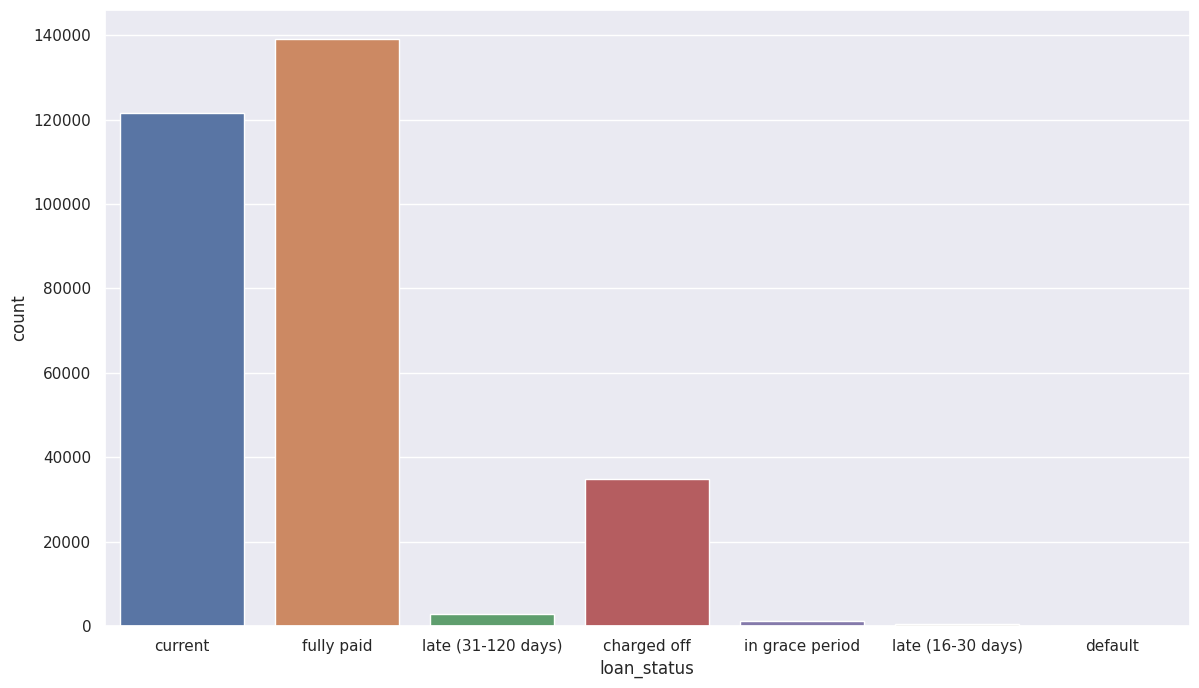

In [ ]:
sns.set(rc={'figure.figsize':(14,8)})
sns.countplot(x = df['loan_status'])

We will restructure this variable to have '1' if it is current or fully paid and '0' for all other categories. We will essentially predict if the loan is 'healthy' or not.

In [ ]:
def status(x):
  if x == "current" or x == "fully paid":
    return 1
  else:
    return 0

In [ ]:
df['loan_status'] = df['loan_status'].apply(lambda x: status(x))

'recoveries' feature in the data-set refers to post charge-off gross recovery.
'collection_recovery_fee' feature in the data-set refers to post charge-off recovery fee. These variables are directly related to the aforementioned dependent variable; hence, we will drop these two features.

In [ ]:
df = df.drop(columns=['recoveries', 'collection_recovery_fee'])

In lieu of one-hot encoding >50 states, let us find another way to consider this information.

<Axes: xlabel='addr_state', ylabel='count'>

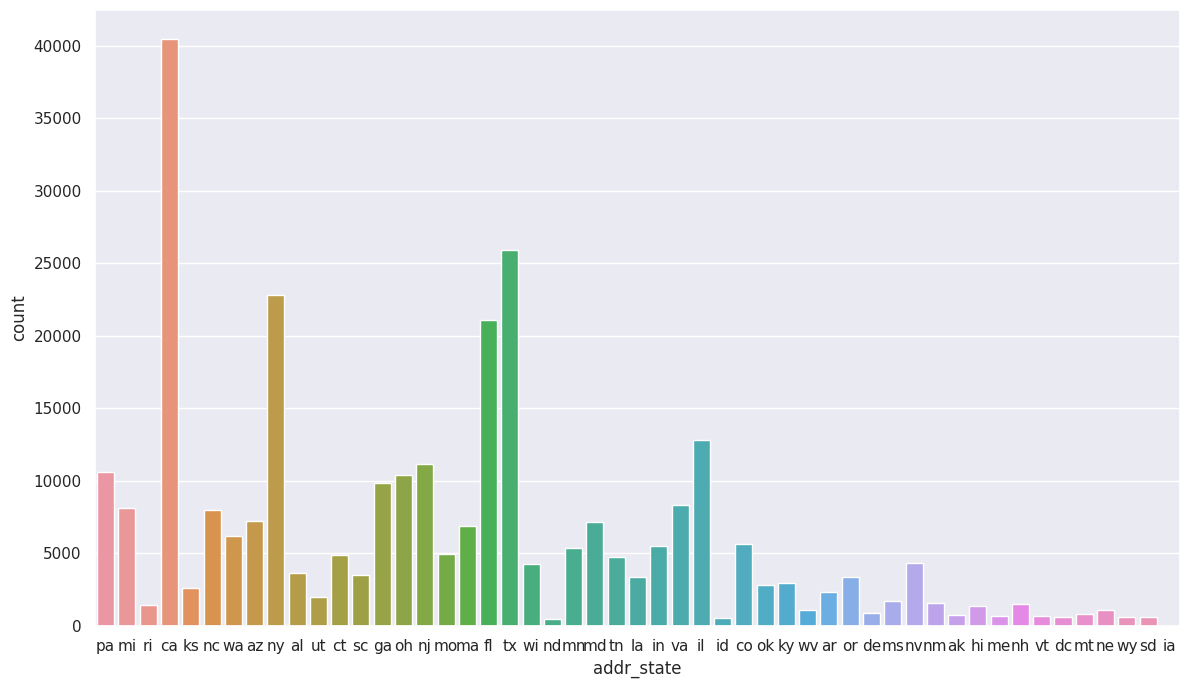

In [ ]:
sns.set(rc={'figure.figsize':(14,8)})
sns.countplot(x = df['addr_state'])

Let us look at the relationship between U.S. state and loan_status

In [ ]:
statbystate = df[['loan_status', 'addr_state']].groupby(['addr_state'], as_index = False, sort=False).sum()
statbystate = statbystate.sort_values(by=['loan_status'], ascending = False)

In [ ]:
statbystate

,addr_state,loan_status
3,ca,35092
19,tx,22397
8,ny,19284
18,fl,18194
28,il,11400
15,nj,9607
0,pa,9184
14,oh,9109
13,ga,8695
27,va,7228


Let us break the U.S. state variable into five dummy variable buckets

In [ ]:
statbystate = statbystate.values.tolist()

In [ ]:
j = 0
thedic = {}
while j < 10:
  thedic[statbystate[j][0]] = 1
  j += 1
while j < 20:
  thedic[statbystate[j][0]] = 2
  j += 1
while j < 30:
  thedic[statbystate[j][0]] = 3
  j += 1
while j < 40:
  thedic[statbystate[j][0]] = 4
  j += 1
while j < len(statbystate):
  thedic[statbystate[j][0]] = 5
  j += 1

In [ ]:
def st(x):
  return thedic[x]

In [ ]:
df['addr_state'] = df['addr_state'].apply(lambda x: st(x))

In [ ]:
# delete unnecessary variables to save on RAM
del statbystate

In [ ]:
# Finally, we can do the one hot encoding of relevant categorical variables.
categorical_features = ['verification_status', 'application_type', 'pymnt_plan', 'addr_state', 'purpose', 'home_ownership']
df = pd.get_dummies(df, columns=categorical_features)
# delete unnecessary variables to save on RAM
del categorical_features

In [ ]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_title,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,seasoning,verification_status_not verified,verification_status_source verified,verification_status_verified,application_type_individual,application_type_joint app,pymnt_plan_n,pymnt_plan_y,addr_state_1,addr_state_2,addr_state_3,addr_state_4,addr_state_5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_any,home_ownership_mortgage,home_ownership_none,home_ownership_other,home_ownership_own,home_ownership_rent
0,9000,9000,9000,36,6.83,277.20,test engineer,5,137000,1,6.60,1,0,6,0,8757.0,62.1,11,7390.90,7390.90,1954.820000,1954.82,1609.10,345.72,0.0,277.20,0,0,0.0,206519.0,14100.0,1,34420.0,5343,62.1,0,0.0,130,72,7,7,3,7,7,1,3,3,3,3,5,3,3,3,6,0,0,1,1,81.8,0.0,0,0,295439.0,18346.0,14100.0,22603.0,5266,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,30000,30000,30000,60,18.45,769.17,production manager / programmer,10,120000,1,10.52,0,0,9,0,28773.0,97.2,15,27052.03,27052.03,7014.780000,7014.78,2947.97,4066.81,0.0,769.17,0,0,365.0,121858.0,29600.0,2,13540.0,0,100.3,0,0.0,113,173,17,17,4,44,17,0,4,5,4,6,3,6,8,5,9,0,0,0,0,100.0,100.0,0,0,160943.0,30689.0,23800.0,5044.0,10199,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,15000,15000,15000,36,7.69,467.91,department manager,10,101000,1,13.96,1,0,9,0,37198.0,83.4,24,0.00,0.00,16849.939071,16849.94,15000.00,1849.94,0.0,467.65,0,0,0.0,167871.0,44600.0,3,18652.0,2304,75.7,0,0.0,170,493,14,14,1,14,16,0,4,5,4,12,5,6,18,5,9,0,0,0,0,83.3,50.0,0,0,293143.0,58613.0,9500.0,48543.0,16132,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,30000,30000,30000,60,13.56,691.23,officer,10,130000,1,7.18,0,0,6,0,11154.0,31.9,8,27826.01,27826.01,4124.780000,4124.78,2173.99,1950.79,0.0,691.23,0,0,0.0,356428.0,41500.0,2,59405.0,25346,37.2,0,0.0,124,124,28,17,2,28,0,0,1,1,2,2,3,3,3,1,6,0,0,0,0,100.0,0.0,0,0,412315.0,33744.0,36500.0,27865.0,3958,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5600,5600,5600,36,14.99,194.10,driver/warehouse,6,29000,1,21.81,0,5,10,0,2720.0,34.4,19,0.00,0.00,6574.240000,6574.24,5600.00,974.24,0.0,3477.97,0,0,0.0,101623.0,7900.0,4,11291.0,2370,49.6,0,0.0,195,117,1,1,0,1,0,0,4,5,4,4,12,7,7,5,10,0,0,0,2,76.5,0.0,0,0,86687.0,101623.0,4700.0,78787.0,6483,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,40000,40000,40000,36,13.99,1366.92,director of curriculum,10,119000,1,17.37,0,0,6,0,95646.0,59.7,12,0.00,0.00,43981.193038,43981.19,40000.00,3981.19,0.0,1364.72,0,0,0.0,95

The number of above features is quite a lot; hence, let us drop some features that are not relevant to the research question based on intuition. The below features that are being dropped are either repeated information or variables that are directly related to the dependent variable.

In [ ]:
drop_columns = ['funded_amnt', 'funded_amnt_inv', 'out_prncp_inv', 'total_pymnt_inv',	'acc_now_delinq',	'chargeoff_within_12_mths', 'delinq_amnt', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq']

In [ ]:
df = df.drop(columns=drop_columns)
# delete unnecessary variables to save on RAM
del drop_columns

In [ ]:
# view final DF
df

,loan_amnt,term,int_rate,installment,emp_title,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,seasoning,verification_status_not verified,verification_status_source verified,verification_status_verified,application_type_individual,application_type_joint app,pymnt_plan_n,pymnt_plan_y,addr_state_1,addr_state_2,addr_state_3,addr_state_4,addr_state_5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_any,home_ownership_mortgage,home_ownership_none,home_ownership_other,home_ownership_own,home_ownership_rent
0,9000,36,6.83,277.20,test engineer,5,137000,1,6.60,1,0,6,0,8757.0,62.1,11,7390.90,1954.820000,1609.10,345.72,0.0,277.20,0,0.0,206519.0,14100.0,1,34420.0,5343,62.1,130,72,7,7,3,7,7,1,3,3,3,3,5,3,3,3,6,0.0,0,0,295439.0,18346.0,14100.0,22603.0,5266,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,30000,60,18.45,769.17,production manager / programmer,10,120000,1,10.52,0,0,9,0,28773.0,97.2,15,27052.03,7014.780000,2947.97,4066.81,0.0,769.17,0,365.0,121858.0,29600.0,2,13540.0,0,100.3,113,173,17,17,4,44,17,0,4,5,4,6,3,6,8,5,9,100.0,0,0,160943.0,30689.0,23800.0,5044.0,10199,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,15000,36,7.69,467.91,department manager,10,101000,1,13.96,1,0,9,0,37198.0,83.4,24,0.00,16849.939071,15000.00,1849.94,0.0,467.65,0,0.0,167871.0,44600.0,3,18652.0,2304,75.7,170,493,14,14,1,14,16,0,4,5,4,12,5,6,18,5,9,50.0,0,0,293143.0,58613.0,9500.0,48543.0,16132,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,30000,60,13.56,691.23,officer,10,130000,1,7.18,0,0,6,0,11154.0,31.9,8,27826.01,4124.780000,2173.99,1950.79,0.0,691.23,0,0.0,356428.0,41500.0,2,59405.0,25346,37.2,124,124,28,17,2,28,0,0,1,1,2,2,3,3,3,1,6,0.0,0,0,412315.0,33744.0,36500.0,27865.0,3958,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5600,36,14.99,194.10,driver/warehouse,6,29000,1,21.81,0,5,10,0,2720.0,34.4,19,0.00,6574.240000,5600.00,974.24,0.0,3477.97,0,0.0,101623.0,7900.0,4,11291.0,2370,49.6,195,117,1,1,0,1,0,0,4,5,4,4,12,7,7,5,10,0.0,0,0,86687.0,101623.0,4700.0,78787.0,6483,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,40000,36,13.99,1366.92,director of curriculum,10,119000,1,17.37,0,0,6,0,95646.0,59.7,12,0.00,43981.193038,40000.00,3981.19,0.0,1364.72,0,0.0,95646.0,125100.0,0,19129.0,29454,59.7,75,287,43,27,0,43,18,0,4,4,6,9,2,6,10,4,6,60.0,0,0,125100.0,95646.0,125100.0,0.0,9070,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
299996,2000,36,12.39,66.81,educator,10,67000,1,19.25,1,0,12,0,44756.0,92.9,24,0.00,2154.650000,2000.00,154.65,0.0,1688.36,0,0.0,388534.0,48200.0,2,32378.0,754,98.0,142,125,28,15,6,51,19,0,3,7,3,5,6,7,12,7,12,100.0,0,0,420493.0,114386.0,38200.0,75793.0,4597,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
299997

This appears to be a reasonably sized data-set to use within Colab's RAM limitations.

There is one remaining categorical variable called 'emp_title' that is the job title of the borrower. As seen below, this variable has many unique values that would make one hot encoding not feasible.

In [ ]:
print("The number of unique values in emp_title is " + str(len(df['emp_title'].unique() )))

The number of unique values in emp_title is 85027


## Word Cloud
We shall prepare word clouds to see if there is a feasible way to bucket values within the emp_title feature.

In [ ]:
import matplotlib.pyplot as plt
import wordcloud
import string

# Remove punctuation and special characters
import string
df_good_status = df[df['loan_status'] == 1]
df_bad_status = df[df['loan_status'] == 0]
gs_emp_titles = df_good_status['emp_title'].str.translate(str.maketrans('', '', string.punctuation))
bs_emp_titles = df_bad_status['emp_title'].str.translate(str.maketrans('', '', string.punctuation))

# Convert text to lowercase
gs_emp_titles = gs_emp_titles.str.lower()
gs_list = gs_emp_titles.tolist()
bs_emp_titles = bs_emp_titles.str.lower()
bs_list = bs_emp_titles.tolist()

# Remove stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# filter out stop words for employee titles on good status loans
gs_filtered_text = []
for title in gs_list:
  for word in title.strip().split():
    if word not in stop_words:
      gs_filtered_text.append(word)

# filter out stop words for employee titles on bad status loans
bs_filtered_text = []
for title in bs_list:
  for word in title.strip().split():
    if word not in stop_words:
      bs_filtered_text.append(word)


# Combine all the words into a single string
gs_text_corpus = ' '.join(gs_filtered_text)
bs_text_corpus = ' '.join(bs_filtered_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Create a WordCloud object
gswordcloud = wordcloud.WordCloud(max_words=200, background_color='white')
bswordcloud = wordcloud.WordCloud(max_words=200, background_color='white')
# Generate word cloud from the text corpus
gswordcloud.generate(gs_text_corpus)
bswordcloud.generate(bs_text_corpus)

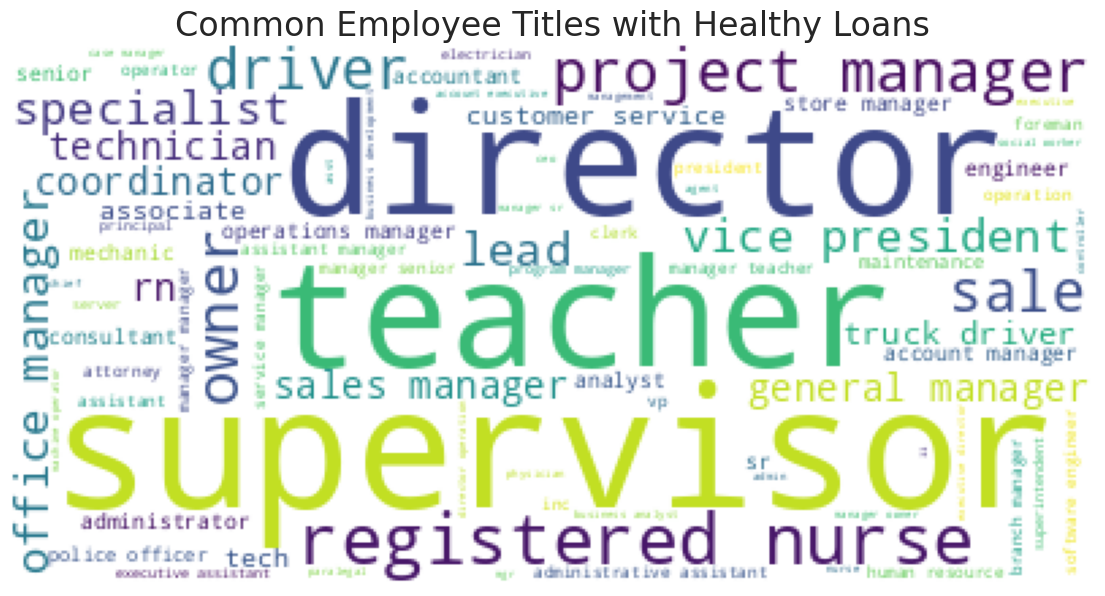

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()

# Display the word cloud for the employee titles with good loan status
ax.imshow(gswordcloud)

# Set axes limits
ax.set_axis_off()

# Show the word cloud
plt.title('Common Employee Titles with Healthy Loans', fontsize=24)
plt.show()

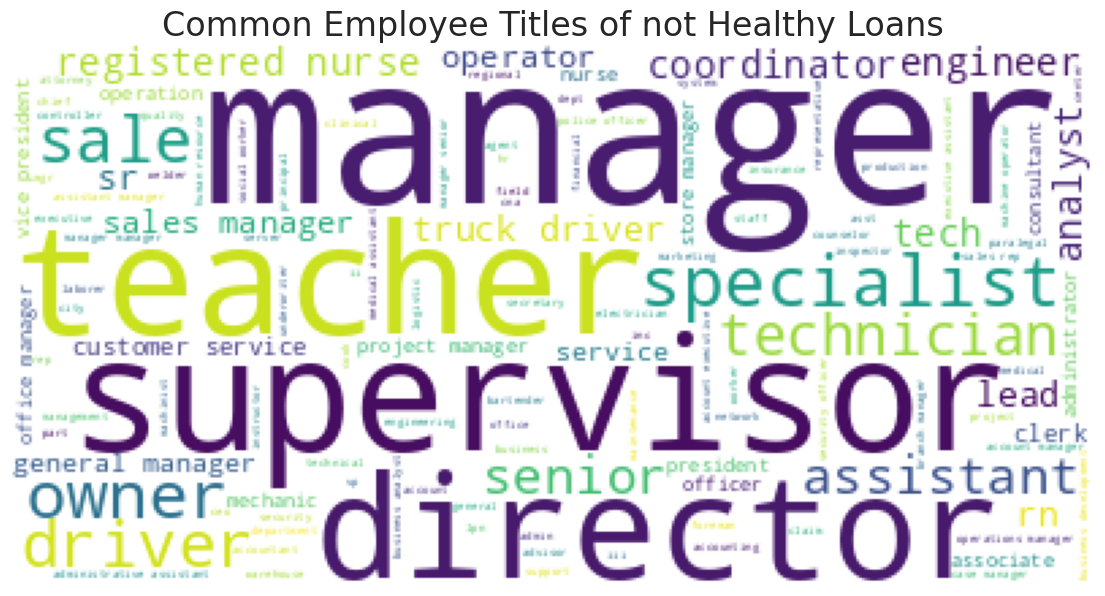

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()

# Display the word cloud on the axes for the loans with bad status
ax.imshow(bswordcloud)

# Set axes limits
ax.set_axis_off()

# Show the word cloud
plt.title('Common Employee Titles of not Healthy Loans', fontsize=24)
plt.show()

The word clouds indicate that *emp_title* has too many unique values. We note that there are other features that capture income of the borrower such as 'annual_inc' which serve as a meaningful proxy for the borrower's employment title. Therefore, we shall drop the emp_title feature from the data-set as well.

In [ ]:
df = df.drop(columns=['emp_title'])

# Exploratory Data Analysis

## Correlation Heatmap
First we will begin by understanding any correlation between fields within the dataset:

In [ ]:
# convert this into a heatmap to use the coloring to compare correlations
# also maybe convert to absolute value, or use a Red Blue color scale where 0 is white
corr_matx = df.corr(numeric_only=True)
corr_matx_cpy = corr_matx.copy()
keep_list = []

# check for collinearity
for col in corr_matx.columns:
  corr_matx_cpy[col] = corr_matx_cpy[col].apply(lambda x: x if abs(x) < 1 else 0)
  keep_list += (corr_matx_cpy[abs(corr_matx_cpy[col]) >= 0.70].index.tolist())

keep_set = list(set(keep_list))
highly_corred_vars = corr_matx.loc[keep_set, keep_set]
print(len(highly_corred_vars))
print(len(corr_matx))

32
84


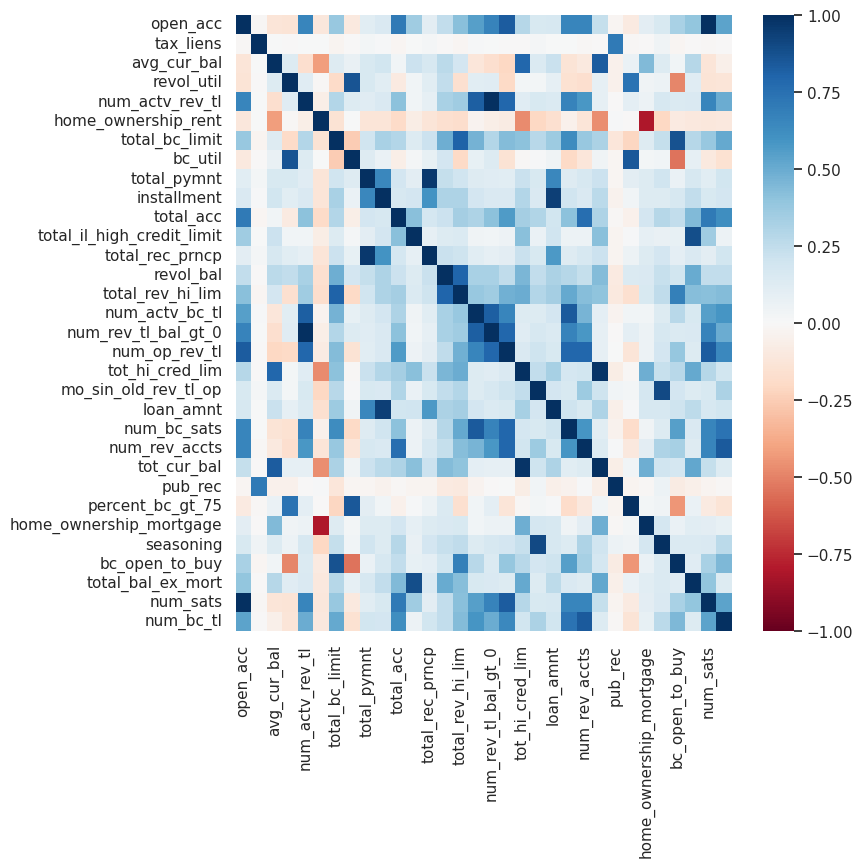

In [ ]:
fig3, axis3 = plt.subplots(figsize=(8,8))
corr_mat = highly_corred_vars
sns.heatmap(
    corr_mat,
    cmap='RdBu',
    vmin=-1,
    vmax=1
)
plt.show()

The heatmap above is just for features in the dataset that have at least 1 correlation with another predictor that is >= 0.70. The picture indicates some multicollinearity within the dataset. We will ensure that this is dealt with.

In [ ]:
# delete unnecessary variables to save on RAM
del corr_matx, corr_matx_cpy, keep_list, keep_set, highly_corred_vars

In [ ]:
# Delete variables to save on RAM
del df_good_status, df_bad_status, gs_emp_titles, bs_emp_titles, gs_list, bs_list, stop_words, gs_filtered_text, bs_filtered_text, gs_text_corpus, bs_text_corpus

In [ ]:
# Delete variables to save on RAM
del gswordcloud, bswordcloud, fig, ax

# Data Modeling

First, let us split the data-set into train and test data-sets.

In [ ]:
# TO-DO: Assign appropriate value to seed and conduct 80/20 train-test split with random_state = seed
train, test = train_test_split(df, test_size=0.20, random_state=seed)

In [ ]:
# del df because we will not need this anymore.
del df

In [ ]:
train

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,seasoning,verification_status_not verified,verification_status_source verified,verification_status_verified,application_type_individual,application_type_joint app,pymnt_plan_n,pymnt_plan_y,addr_state_1,addr_state_2,addr_state_3,addr_state_4,addr_state_5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_any,home_ownership_mortgage,home_ownership_none,home_ownership_other,home_ownership_own,home_ownership_rent
254099,17000,36,6.72,522.74,5,84500,1,22.64,0,0,11,1,11154.0,60.3,26,11251.34,6782.930000,5748.66,1034.27,0.00,522.74,0,0.0,78673.0,18500.0,3,7152.0,5771,53.8,149,172,10,10,0,49,13,1,1,2,1,6,17,2,9,2,11,0.0,1,0,111470.0,78673.0,12500.0,92970.0,5632,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
53461,8325,36,14.47,286.44,5,95000,1,3.09,1,0,8,0,6752.0,57.9,17,0.00,9838.769999,8325.00,1513.77,0.00,4682.92,0,0.0,259416.0,12000.0,5,32427.0,3357,58.6,147,123,3,3,3,3,7,5,5,6,5,8,2,7,11,6,8,20.0,0,0,266594.0,6752.0,7600.0,0.0,5051,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
247984,25000,60,19.24,651.82,10,88000,1,28.13,1,0,13,0,8180.0,42.6,34,0.00,36066.551366,25000.00,11033.96,32.59,14583.21,0,0.0,391255.0,19200.0,9,30097.0,311,93.2,136,132,7,7,5,7,7,2,1,7,1,3,12,9,17,7,13,100.0,0,0,429001.0,65071.0,4600.0,80869.0,7124,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
209067,40000,36,6.71,1229.79,6,2000000,1,4.76,0,0,16,0,474417.0,50.5,35,29681.79,12282.990000,10318.21,1964.78,0.00,1229.79,0,0.0,5327039.0,672900.0,9,332940.0,73623,51.3,152,237,4,4,11,19,6,0,6,7,7,8,10,9,13,7,16,14.3,0,0,5850873.0,554263.0,171400.0,74626.0,7520,0,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
185997,9750,36,15.61,340.91,10,33000,1,31.89,0,1,12,1,3508.0,25.4,26,0.00,12280.241127,9750.00,2530.24,0.00,340.75,0,0.0,25979.0,13800.0,8,2362.0,957,71.9,111,479,2,2,3,14,5,3,4,6,4,10,4,10,18,6,11,50.0,1,0,41635.0,25979.0,3400.0,27835.0,15675,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,35000,60,12.13,780.86,1,102000,1,7.66,0,1,6,1,8571.0,53.9,22,31918.32,5418.850000,3081.68,2337.17,0.00,780.86,0,0.0,309186.0,15900.0,5,51531.0,3224,35.5,153,268,5,1,2,5,1,0,1,4,1,7,4,4,16,4,6,0.0,1,0,321955.0,31835.0,5000.0,29755.0,8401,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
259178,29175,36,15.80,1022.83,10,65000,1,23.72,0,0,22,0,39483.0,62.5,46,0.00,36821.789324,29175.00,7646.79,0.00,1022.73,0,0.0,43137.0,63200.0,7,2054.0,15782,67.8,196,196,6,6,0,7,7,0,6,10,10,20,11,19,35,10,22,30.0,0,0,72825.0,43137.0,49000.0,9625.0,6999,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
131932,15500,60,23.28,439.45,10,58000,0,22.72,0,0,10,0,6260.0,81.3,16,0.00,15853.020000,6591.56,8345.3

<Axes: xlabel='loan_status', ylabel='count'>

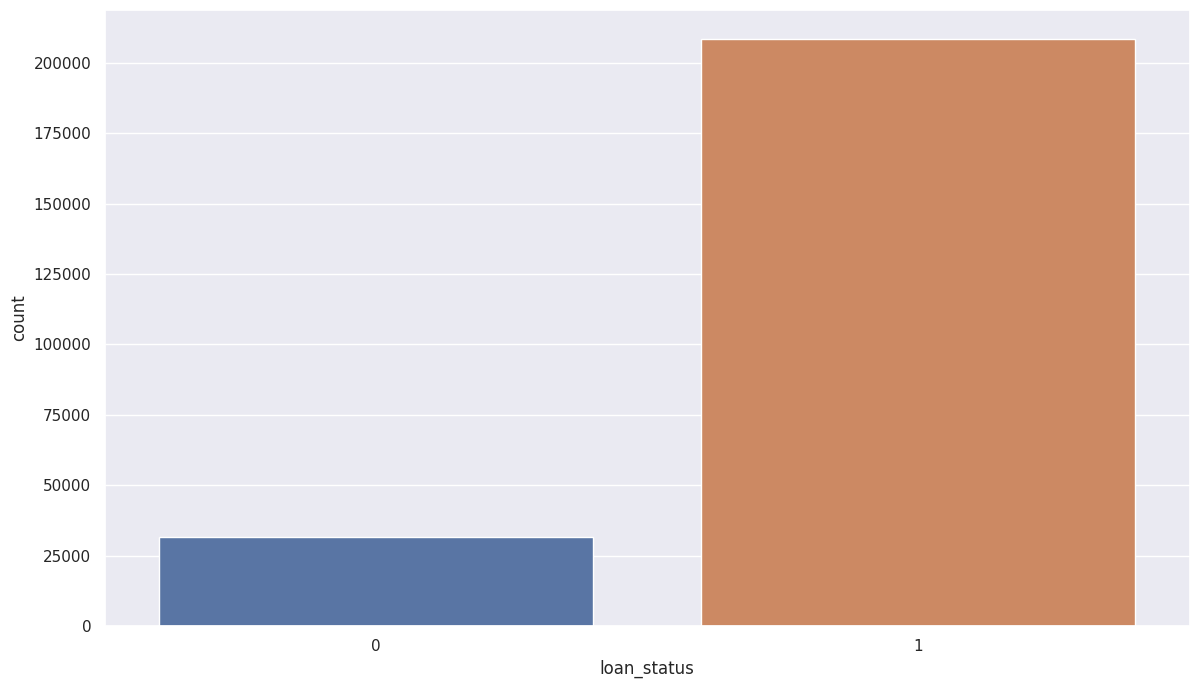

In [ ]:
sns.countplot(x = train['loan_status'])

As seen above, the data is very imbalanced. Let us balance the data.

In [ ]:
Y_train = train['loan_status']
X_train = train.drop(columns=['loan_status'])

In [ ]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=seed)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(X_train, Y_train)
train = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [ ]:
# delete unnecessary variables to save on RAM
del sm, oversampled_X, oversampled_Y

<Axes: xlabel='loan_status', ylabel='count'>

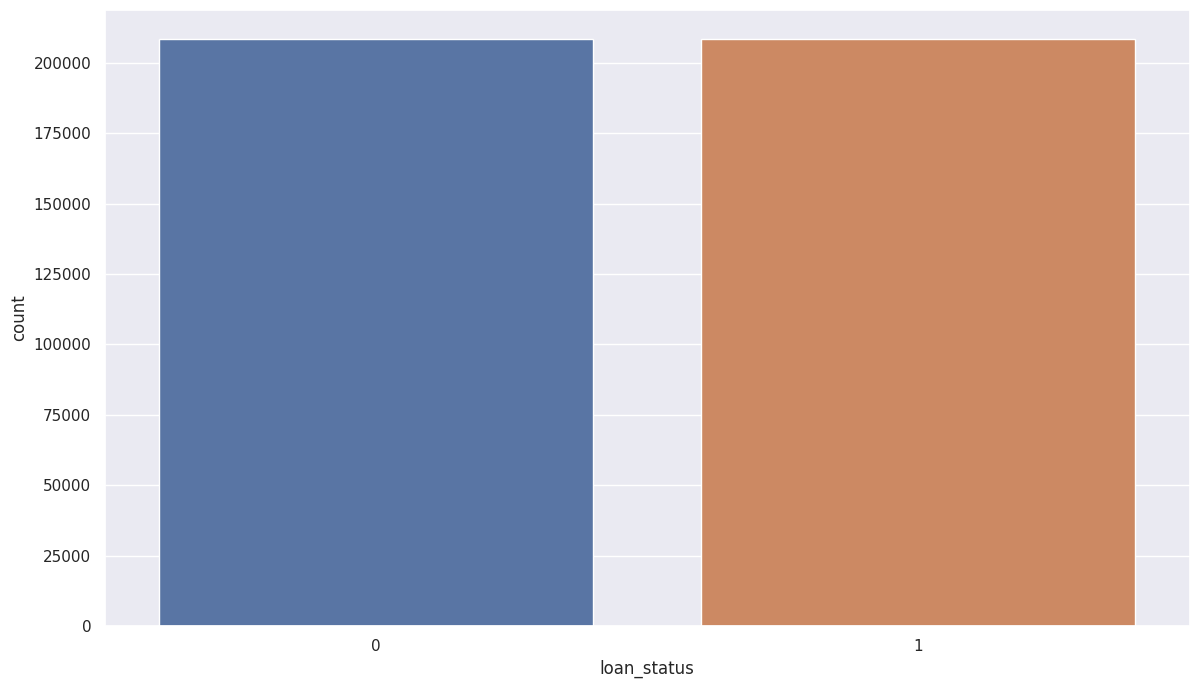

In [ ]:
sns.countplot(x = train['loan_status'])

Now, our dataset is balanced and we can proceed to modeling.

## Train-Test Split

Let us separate the training dataset into features and the dependent variable.

In [ ]:
Y_train = train['loan_status']
X_train = train.drop(columns=['loan_status'])

## Principal Component Analysis
Let us use PCA to get rid of multicollinearity and reduce the dimensions

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
X = StandardScaler().fit_transform(X_train)

# Instantiate and Fit PCA
pca = PCA(n_components = 40)
X2 = pca.fit_transform(X)

# Save the explained variance ratios into variable called "explained_variance_ratios"
np.set_printoptions(suppress = True)
explained_variance_ratios = pca.explained_variance_ratio_

# Save the CUMULATIVE explained variance ratios into variable called "cum_evr"
cum_evr = np.cumsum(explained_variance_ratios)

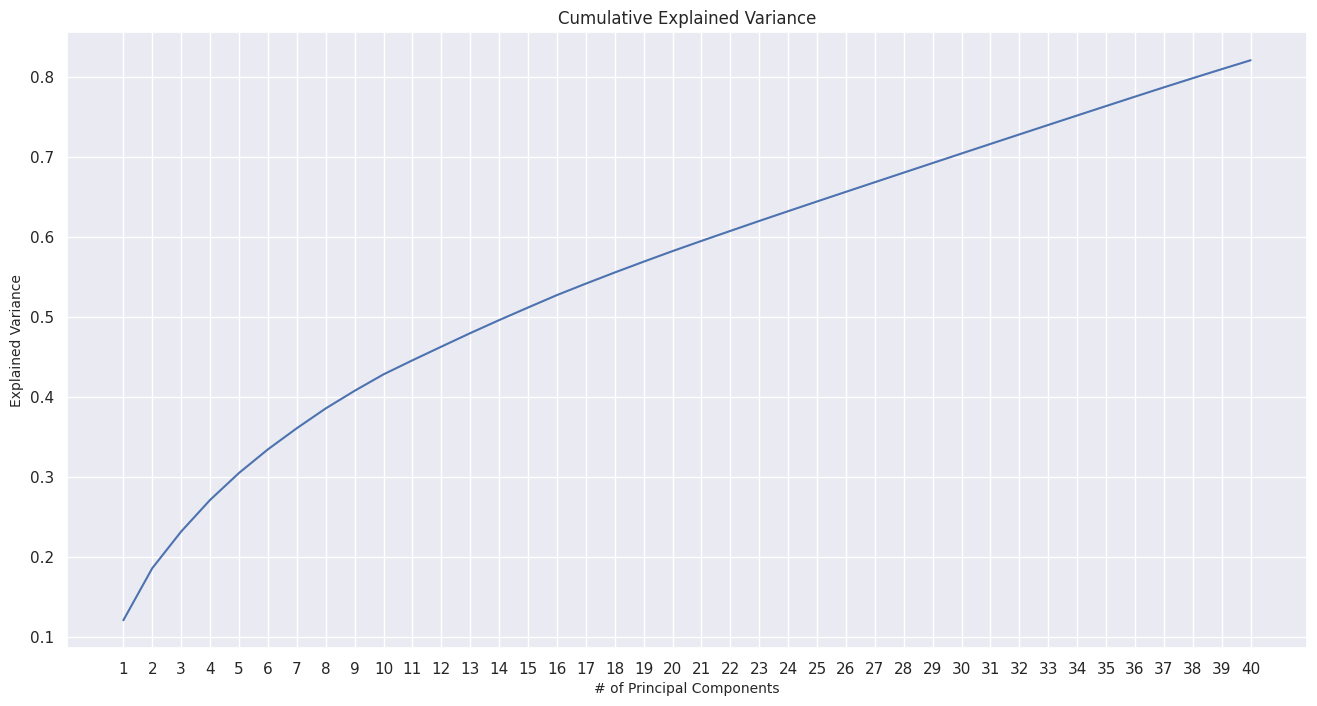

In [ ]:
sns.set(rc={'figure.figsize':(16,8)})
g = sns.lineplot(x = range(1,len(cum_evr)+1), y = cum_evr)
g.set_xticks(range(1,len(cum_evr)+1))
plt.title('Cumulative Explained Variance')
plt.xlabel('# of Principal Components', fontsize = 10)
plt.ylabel('Explained Variance', fontsize = 10)
plt.show()

In [ ]:
# deleting unnecessary variables to save on RAM
del X, pca, X2, explained_variance_ratios, cum_evr, g

We can reduce the number of dimensions to 38 via PCA to capture 80% of the variance in the data-set.

In [ ]:
# preparing test datasets
Y_test = test['loan_status']
X_test = test.drop(columns=['loan_status'])

# getting pca'ed version of datasets
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transform = scaler.transform(X_train)
X_test_transform = scaler.transform(X_test)

# setting up the PCA
pca = PCA(n_components = 38)
pca.fit(X_train_transform)
X_train_pca = pca.transform(X_train_transform)
X_test_pca = pca.transform(X_test_transform)

## Logistic Regression

In [ ]:
# use log regression as a baseline
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_pca, Y_train)
y_pred = model.predict(X_test_pca)
test_accuracy = model.score(X_test_pca, Y_test)
print("The test accuracy for the logistic regression model is " + str(test_accuracy))

The test accuracy for the logistic regression model is 0.8607


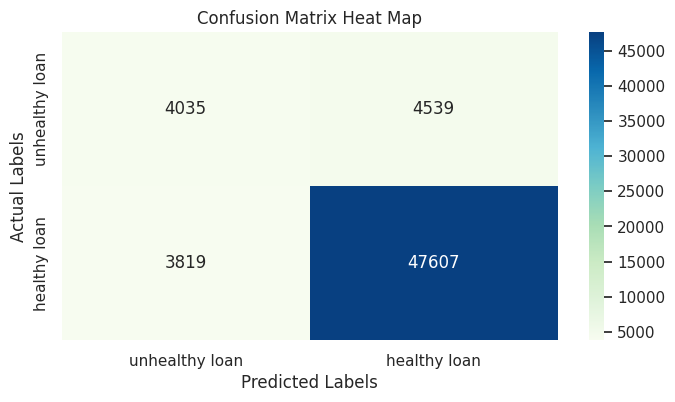

In [ ]:
# visualize a confusion matrix
from sklearn.metrics import confusion_matrix
cmatrix = pd.DataFrame(confusion_matrix(y_pred, Y_test))
sns.set(rc={'figure.figsize':(8,4)})
g = sns.heatmap(data = cmatrix, fmt = "g", annot = True, cmap = "GnBu")
plt.title('Confusion Matrix Heat Map')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
g.set_xticklabels(['unhealthy loan', 'healthy loan'])
g.set_yticklabels(['unhealthy loan', 'healthy loan'])
plt.show()

The logistic regression model serves as a reasonable baseline with regards to predicting whether a loan is healthy or not.

In [ ]:
del cmatrix, g

## Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(20), max_iter= 600)
model.fit(X_train_pca,Y_train)

MLPClassifier(hidden_layer_sizes=20, max_iter=600)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = model.predict(X_test_pca)
print("The accuracy score for the neural network model is " + str(accuracy_score(y_pred, Y_test)))

The accuracy score for the neural network model is 0.95365


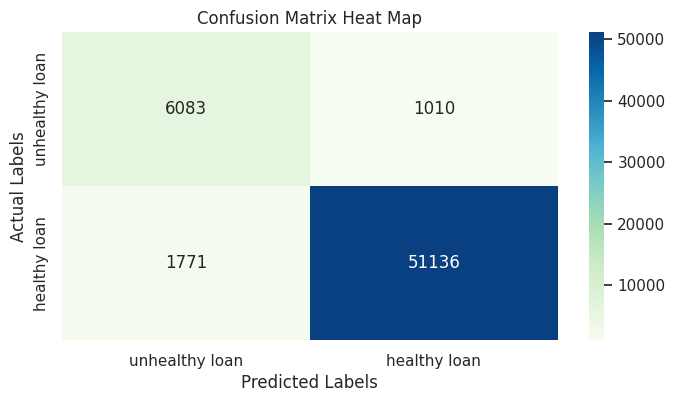

In [ ]:
# visualize a confusion matrix
cmatrix = pd.DataFrame(confusion_matrix(y_pred, Y_test))
sns.set(rc={'figure.figsize':(8,4)})
g = sns.heatmap(data = cmatrix, fmt = "g", annot = True, cmap = "GnBu")
plt.title('Confusion Matrix Heat Map')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
g.set_xticklabels(['unhealthy loan', 'healthy loan'])
g.set_yticklabels(['unhealthy loan', 'healthy loan'])
plt.show()

There is a meaningful improvement in using a neural network model in predicting whether a loan is healthy or not.

In [ ]:
del cmatrix, g

## Ridge Regression

Now, we shall shift to models that do not use principal components such as Ridge Regression and Random Forest Classifiers.

In [ ]:
from sklearn.linear_model import RidgeClassifier
# TO-DO: Initialize model with alpha = 10
model = RidgeClassifier(alpha = 10)
model.fit(X_train_transform, Y_train)
y_pred = model.predict(X_test_transform)
test_accuracy = accuracy_score(y_pred, Y_test)
print("The test accuracy for the ridge regression model is " + str(test_accuracy))

The test accuracy for the ridge regression model is 0.9363333333333334


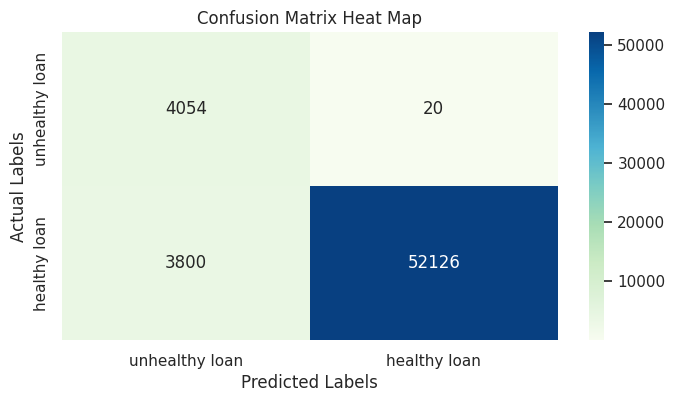

In [ ]:
# visualize a confusion matrix
cmatrix = pd.DataFrame(confusion_matrix(y_pred, Y_test))
sns.set(rc={'figure.figsize':(8,4)})
g = sns.heatmap(data = cmatrix, fmt = "g", annot = True, cmap = "GnBu")
plt.title('Confusion Matrix Heat Map')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
g.set_xticklabels(['unhealthy loan', 'healthy loan'])
g.set_yticklabels(['unhealthy loan', 'healthy loan'])
plt.show()

The ridge regression model uses scaled data without principal components. The ridge regression model generates a healthy accuracy score; however, it does not perform as well as the neural network model. This is likely due to ridge regression model being linear in nature.

In [ ]:
del cmatrix, g

## Random Forest

We used best subset selection to find the 'best' features to include within the Random Forest Classifier Model along with the 'best' hyperparameters to use within the model via Cross Validation in a supplementary notebook that is submitted on GradeScope. In this file, we will display the output of the Random Forest Classifier Model with all features and the 'best'features. The cross validation process suggested that we use a model with n_estimators = 90 with other parameters left at their default setting; hence, we will use such a model for 'all' features and the 'best' features for the purpose of comparison.

In [ ]:
# import the random forest classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=seed, n_estimators=90).fit(X_train, Y_train)
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_pred, Y_test)
print("The test accuracy for the random forest model is " + str(test_accuracy))

The test accuracy for the random forest model is 0.9764166666666667


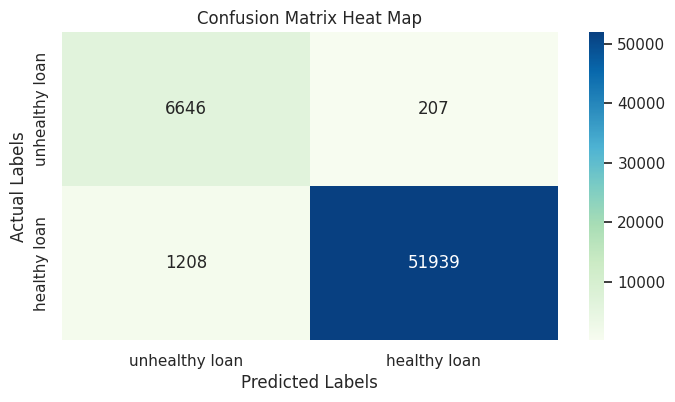

In [ ]:
# visualize a confusion matrix
cmatrix = pd.DataFrame(confusion_matrix(y_pred, Y_test))
sns.set(rc={'figure.figsize':(8,4)})
g = sns.heatmap(data = cmatrix, fmt = "g", annot = True, cmap = "GnBu")
plt.title('Confusion Matrix Heat Map')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
g.set_xticklabels(['unhealthy loan', 'healthy loan'])
g.set_yticklabels(['unhealthy loan', 'healthy loan'])
plt.show()

There is a meaningful improvement in using a random forest model in predicting whether a loan is healthy or not. Note that we do not use scaled data in this model because that is unnecessary for random forest models. Additionally, it is our understanding that random forest models are less impacted by multicollinearity; hence, we didn't use PCA'd data in this model. Hence, the model has the benefit of using 100% of the variance in the data-set.

Now, we shall run the same model with the 'best' features as discovered in the submitted supplementary file.

In [ ]:
# best features
optimal_features = ['total_rec_late_fee', 'pymnt_plan_n', 'purpose_other', 'home_ownership_rent', 'purpose_medical', 'purpose_moving', 'pymnt_plan_y', 'purpose_vacation', 'purpose_renewable_energy', 'home_ownership_none', 'collections_12_mths_ex_med', 'home_ownership_any', 'home_ownership_other', 'purpose_wedding', 'purpose_major_purchase', 'purpose_house', 'purpose_car', 'pub_rec', 'addr_state_5', 'purpose_small_business', 'tax_liens', 'term', 'addr_state_3', 'addr_state_4', 'emp_length', 'purpose_home_improvement', 'application_type_joint app', 'application_type_individual', 'pub_rec_bankruptcies', 'home_ownership_own', 'home_ownership_mortgage', 'purpose_credit_card', 'purpose_debt_consolidation', 'addr_state_2', 'addr_state_1', 'verification_status_not verified', 'verification_status_verified', 'verification_status_source verified', 'num_accts_ever_120_pd', 'out_prncp', 'total_rec_prncp', 'loan_amnt', 'total_pymnt', 'last_pymnt_amnt', 'installment', 'total_bc_limit', 'open_acc', 'total_rec_int', 'int_rate']
print("By selecting the best features, we reduce dimensionality to " + str(len(optimal_features)))

By selecting the best features, we reduce dimensionality to 49


In [ ]:
model = RandomForestClassifier(random_state=seed, n_estimators=90).fit(X_train[optimal_features], Y_train)
y_pred = model.predict(X_test[optimal_features])
test_accuracy = accuracy_score(y_pred, Y_test)
print("The test accuracy for this random forest model is " + str(test_accuracy))

The test accuracy for this random forest model is 0.9809166666666667


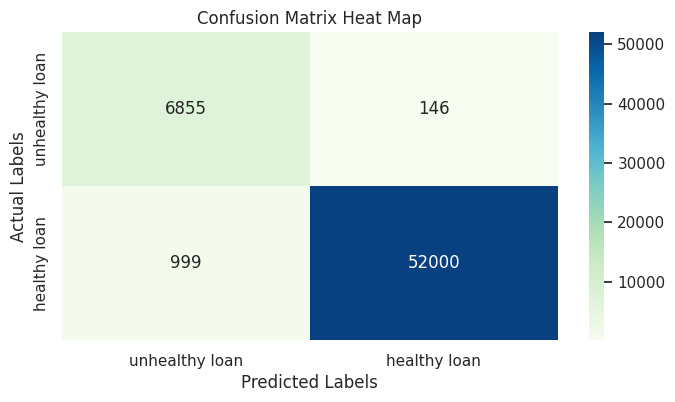

In [ ]:
# visualize a confusion matrix
cmatrix = pd.DataFrame(confusion_matrix(y_pred, Y_test))
sns.set(rc={'figure.figsize':(8,4)})
g = sns.heatmap(data = cmatrix, fmt = "g", annot = True, cmap = "GnBu")
plt.title('Confusion Matrix Heat Map')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
g.set_xticklabels(['unhealthy loan', 'healthy loan'])
g.set_yticklabels(['unhealthy loan', 'healthy loan'])
plt.show()

This is the best model that we were able to use on this dataset (as evidenced by the better accuracy score and confusion heatmap).

In [ ]:
del cmatrix, g, optimal_features, model, y_pred, test_accuracy

# Model Comparisons
We explored four different approaches to the modeling portion of this project. First, we used a logistic regression with Principal Component Analysis (PCA). Of the 4 approaches, this yielded the lowest test accuracy score (albeit, it was still meaningful at > 80%). Logistic regression is a generalized linear model which is probably one reason as to why its' test accuracy estimate was relatively lower (does not work well with non-linear relationships).

Second, we used a Neural Network model with 20 hidden layers which performed considerably well on the test data (the 2nd best model). Unlike ridge and logistic regression, neural networks can encapsulate non-linear relationships in the data which is likely what led to its' performance being better on the test data. However, it is acknowledged that neural networks require large datasets to be trained appropriately.

Third, we used a Ridge Regression model which performed the 3rd best on the test data. This likely did better than logistic regression because it utilized the non-PCA'd data to train (captured more variance in the data-set). However, as mentioned previously, it can't handle non-linear relationships well, which is why it underperformed relative to the neural network model and the random forest models.

Lastly, we used Random Forest Models which performed the best with accuracy scores > 97%. The Random Forest models used non-PCA'd data (thus captured more variance in the data-set). Additionally, it has the ability to capture non-linear relationships in the data. This explains why it did better than logistic and ridge regression. Lastly, random forests are, generally, less prone to overfitting than neural networks which is likely why the random forest models did better than the neural network model.

It is noted that the model with the best features did the best on the test data-set than any other model that we used in our dataset. The key question is as to whether the +.45 percentage point improvement in using the random forest model with the 'best' features is worth the extra hassle of taking time to 'find' the best features and 'best' parameters for the model. This depends on the context. In this context, we would argue that the 'extra hassle' is necessary.

The reduction in misclassified 'unhealthy' loans by using the aforementioned model is 209. Similarly, the reduction in misclassified 'healthy' loans by using the aforementioned model is 61. If an unhealthy loan is classified as a healthy loan, the firm could make a loss on treating the borrower as a healthy borrower. On the other hand, if a healthy loan is classifed as an unhealthy loan, the firm could end up irritating its' good borrowers. Once again, the context of the research question informs the required magnitude of the test accuracy score.

The best features also provide 'additional' information with regards to what features are actually relevant to the research question in lieu of throwing everything into a black box for prediction purposes. The best features from the random forest model indicate that features associated with the purpose of the loan, characteristics of home ownership, borrower location, employment length, income, loan amount, etc. are particularly important to predict the health of the loan.





# Description of Challenges or Obstacles Faced

First, we ran into RAM limitations with regards to reading and working with such a large dataset (originally > 2MM rows). The file was so large that we could not upload the file directly into the Colab drive from our personal computers. We had to download the file from Kaggle as part of the code (as seen above). We dealt with this by a) reading the file in chunks (albeit, concatenating the chunks took quite a bit of memory as well) and b) using a sample of the dataset (albeit a rather large one at 300K rows). Of course, a supplementary file uses the entire dataset; however, we had to use Colab Pro to work on that file.

Second, the data had a significant amount of features and the state categorical variable had too many values to one hot encode. We addressed this problem by deleting unnecessary features (based on expert intuition - one of the group members works in lending) and transforming the state variable into five bucket variables by trending each state against the # of healthy loans in that state.

Third, given the nature of loan data, the data was materially imbalanced in that there were a few 'unhealthy' loans and materially more 'healthy' loans. We addressed this by using Synthetic Minority Oversampling Technique (SMOTE) to balance the training dataset. This algorithm essentially takes existing examples of the minority class, finds k-nearest neighbors for each example, and takes random samples of the neighbor features to generate synthetic examples for this minority class.

Fourth, there was a meaningful amount of multicollinearity in the dataset. We addressed this by using principal components in the methods that are susceptible to multicollinearity (such as neural networks and logistic regression). It is our understanding that Ridge Regression and Random Forests are not meaningfully impacted by multicollinearity; hence, these models used non-PCA'd data.

# Potential Next Steps / Future Direction

Given the size of the data, the next step would be to work with this data in a parallel processing environment. We could have transformed the data-set into a spark data frame and used parallel processing machine learning methods; however, preparing the schema for a spark dataframe with the material number of features would have been infeasible for us in the short time frame that we had for this group project (along with other deliverables that are part of CIS 545 - most importantly the final exam).

Another important step would be to find a systematic way to drop features in lieu of what we did which was to read the data dictionary ourselves and drop features that needed to be dropped based on our expert intuition. It is likely that we might have not dropped some features that needed to be dropped given that the original number of features was 145.

However, overall, we believe that we have demonstrated a reasonable ability to engage in data science to answer questions with an appropriate understanding of the methods used. Please let us know if you have any questions.